In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import torch
import pandas as pd

# === DYNAMIC PATH SETUP ===
# Get the directory of this notebook
notebook_dir = Path.cwd()
project_root = notebook_dir.parent  # Go up one level to Project folder (if notebook is in subfolder)

# Find libmoon directory (search in current and parent directories)
if (notebook_dir / 'libmoon').exists():
    libmoon_base = notebook_dir / 'libmoon'
elif (project_root / 'libmoon').exists():
    libmoon_base = project_root / 'libmoon'
else:
    # Fallback: assume it's relative to notebook location
    libmoon_base = notebook_dir / 'libmoon'
    
libmoon_package = libmoon_base / 'libmoon'  # This is where the actual package code is
results_dir = notebook_dir / 'results'  # Create results in notebook's directory

# Add libmoon to path
sys.path.insert(0, str(libmoon_base))

# Create output directories
results_dir.mkdir(exist_ok=True)
(results_dir / 'metrics').mkdir(exist_ok=True)
(results_dir / 'solver_outputs').mkdir(exist_ok=True)
(results_dir / 'figures').mkdir(exist_ok=True)
(results_dir / 'reproducibility').mkdir(exist_ok=True)

print(f"Notebook directory: {notebook_dir}")
print(f"Project root: {project_root}")
print(f"LibMOON repo path: {libmoon_base}")
print(f"LibMOON package path: {libmoon_package}")
print(f"Results directory: {results_dir}")
print(f"✓ Environment setup complete. Do NOT modify libmoon/ directory.")

Project root: /home/kjar/home/cs5640/Project2
LibMOON repo path: /home/kjar/home/cs5640/Project2/libmoon
LibMOON package path: /home/kjar/home/cs5640/Project2/libmoon/libmoon
Results directory: /home/kjar/home/cs5640/Project2/results
✓ Environment setup complete. Do NOT modify libmoon/ directory.


In [ ]:
try:
    from arff import load as arff_load
except ImportError:
    print("Installing liac-arff...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "liac-arff", "-q"])
    from arff import load as arff_load

# Load German Credit ARFF file - search in multiple locations
possible_locations = [
    libmoon_base / 'german_credit.arff',
    notebook_dir / 'libmoon' / 'german_credit.arff',
    notebook_dir / 'german_credit.arff',
    project_root / 'libmoon' / 'german_credit.arff',
]

arff_file = None
for loc in possible_locations:
    if loc.exists():
        arff_file = loc
        break

if arff_file is None:
    raise FileNotFoundError(f"German Credit ARFF file not found in any of these locations:\n" + 
                          "\n".join(str(l) for l in possible_locations))

print(f"Loading German Credit dataset from: {arff_file}")

with open(arff_file, 'r', encoding='latin-1') as f:
    arff_data = arff_load(f)

# Convert to pandas DataFrame
df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
print(f"\n✓ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum().sum()} total missing values")
print(f"\nTarget variable distribution:\n{df['class'].value_counts()}")

Loading German Credit dataset from: /home/kjar/home/cs5640/Project2/libmoon/german_credit.arff

✓ Dataset loaded successfully!
Shape: (1000, 21)

Column names:
['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 'class']

First few rows:
  checking_status  duration                  credit_history  \
0              <0       6.0  critical/other existing credit   
1        0<=X<200      48.0                   existing paid   
2     no checking      12.0  critical/other existing credit   
3              <0      42.0                   existing paid   
4              <0      24.0              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Prepare data
print("Preparing preprocessing pipeline...")

# Separate features and targeta
X = df.drop('class', axis=1).copy()
y = df['class'].copy()

# Convert target to numeric (good=0, bad=1)
y_numeric = (y == 'bad').astype(int)

# Identify categorical and numeric features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {len(categorical_features)}")
print(f"Numeric features: {len(numeric_features)}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Fit and transform
X_processed = preprocessor.fit_transform(X)
print(f"\n✓ Preprocessed feature matrix shape: {X_processed.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test class distribution: {pd.Series(y_test).value_counts().to_dict()}")

# Convert to torch tensors
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.FloatTensor(y_train.values if hasattr(y_train, 'values') else y_train).unsqueeze(1)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.FloatTensor(y_test.values if hasattr(y_test, 'values') else y_test).unsqueeze(1)

print(f"\n✓ Data preprocessing complete!")

Preparing preprocessing pipeline...
Categorical features: 13
Numeric features: 7

✓ Preprocessed feature matrix shape: (1000, 61)
Train set: (800, 61)
Test set: (200, 61)
Train class distribution: {0: 560, 1: 240}
Test class distribution: {0: 140, 1: 60}

✓ Data preprocessing complete!


In [4]:
import torch

# Define the balanced problem class
class GermanCreditProblemBalanced:
    """
    BALANCED German Credit problem.
    Includes a 'complexity_weight' to balance the objectives.
    """
    
    def __init__(self, input_dim, hidden_dim=16, complexity_weight=100.0):
        self.name = "GermanCredit"
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_obj = 2
        self.n_var = input_dim * hidden_dim + hidden_dim + hidden_dim + 1
        self.bounds = torch.tensor([[-5.0] * self.n_var, [5.0] * self.n_var])
        self.problem_name = 'GermanCreditProblem'
        
        # This weight balances the two objectives
        self.complexity_weight = complexity_weight
        print(f"✓ Balanced Problem created with Complexity Weight: {self.complexity_weight}")

    def evaluate(self, X):
        """ Vectorized evaluation """
        if isinstance(X, np.ndarray): X = torch.FloatTensor(X)
        pop_size = X.shape[0]
        
        w1_end = self.input_dim * self.hidden_dim
        b1_end = w1_end + self.hidden_dim
        w2_end = b1_end + self.hidden_dim
        
        W1 = X[:, :w1_end].reshape(pop_size, self.hidden_dim, self.input_dim)
        b1 = X[:, w1_end:b1_end].unsqueeze(1)
        W2 = X[:, b1_end:w2_end].reshape(pop_size, self.hidden_dim, 1)
        b2 = X[:, w2_end:].reshape(pop_size, 1, 1)
        
        X_input = X_train_torch.unsqueeze(0)
        h = torch.relu(torch.matmul(X_input, W1.transpose(1, 2)) + b1)
        logits = torch.matmul(h, W2) + b2
        
        preds_probs = torch.sigmoid(logits).squeeze(-1)
        targets = y_train_torch.squeeze().unsqueeze(0).expand(pop_size, -1)
        error = torch.nn.functional.binary_cross_entropy(preds_probs, targets, reduction='none').mean(dim=1)
        
        # --- THE FIX ---
        num_params = (self.input_dim * self.hidden_dim) + self.hidden_dim
        l2_norm = (torch.norm(W1.reshape(pop_size, -1), dim=1) + torch.norm(W2.reshape(pop_size, -1), dim=1)) / num_params
        
        # Apply the balancing weight
        complexity = l2_norm * self.complexity_weight
        # ---------------
        
        return torch.stack([error, complexity], dim=1)


problem = GermanCreditProblemBalanced(
    input_dim=X_train_torch.shape[1], 
    hidden_dim=8, 
    complexity_weight=100.0  # Adjust this weight if needed
)

✓ Balanced Problem created with Complexity Weight: 100.0


In [5]:

# Try to import all gradient solvers
grad_imports = {}
try:    
    from libmoon.solver.gradient.methods import EPOSolver, MGDAUBSolver, RandomSolver
    grad_imports['EPOSolver'] = EPOSolver
    grad_imports['MGDAUBSolver'] = MGDAUBSolver
    grad_imports['RandomSolver'] = RandomSolver
    print("✓ Basic gradient solvers imported: EPOSolver, MGDAUBSolver, RandomSolver")
except Exception as e:
    print(f"⚠ PMGDASolver not available: {type(e).__name__}")

try:
    from libmoon.solver.gradient.methods.pmgda_solver import PMGDASolver
    grad_imports['PMGDASolver'] = PMGDASolver
    print("✓ PMGDASolver imported")
except Exception as e:
    print(f"⚠ PMGDASolver not available: {type(e).__name__}")

try:
    from libmoon.solver.gradient.methods.gradhv_solver import GradHVSolver as HVGradSolver
    grad_imports['HVGradSolver'] = HVGradSolver
    print("✓ HVGradSolver imported")
except Exception as e:
    print(f"⚠ HVGradSolver not available: {type(e).__name__}")

try:
    from libmoon.solver.gradient.methods.moosvgd_solver import MOOSVGDSolver
    grad_imports['MOOSVGDSolver'] = MOOSVGDSolver
    print("✓ MOOSVGDSolver imported")
except Exception as e:
    print(f"⚠ MOOSVGDSolver not available: {type(e).__name__}")

try:
    from libmoon.solver.gradient.methods.pmtl_solver import PMTLSolver
    grad_imports['PMTLSolver'] = PMTLSolver
    print("✓ PMTLSolver imported")
except Exception as e:
    print(f"⚠ PMTLSolver not available: {type(e).__name__}")
    

print(grad_imports)

✓ Basic gradient solvers imported: EPOSolver, MGDAUBSolver, RandomSolver
✓ PMGDASolver imported
✓ HVGradSolver imported
✓ MOOSVGDSolver imported
✓ PMTLSolver imported
{'EPOSolver': <class 'libmoon.solver.gradient.methods.epo_solver.EPOSolver'>, 'MGDAUBSolver': <class 'libmoon.solver.gradient.methods.mgda_solver.MGDAUBSolver'>, 'RandomSolver': <class 'libmoon.solver.gradient.methods.random_solver.RandomSolver'>, 'PMGDASolver': <class 'libmoon.solver.gradient.methods.pmgda_solver.PMGDASolver'>, 'HVGradSolver': <class 'libmoon.solver.gradient.methods.gradhv_solver.GradHVSolver'>, 'MOOSVGDSolver': <class 'libmoon.solver.gradient.methods.moosvgd_solver.MOOSVGDSolver'>, 'PMTLSolver': <class 'libmoon.solver.gradient.methods.pmtl_solver.PMTLSolver'>}


In [6]:
from libmoon.util.prefs import get_uniform_pref
from pymoo.config import Config
Config.warnings['not_compiled'] = False

# # Create preferences
# prefs = get_uniform_pref(n_prob=5, n_obj=problem.n_obj, clip_eps=1e-2)

# # Random initialization - no synthetic_init needed!
# x_init = torch.randn(prefs.shape[0], problem.n_var, requires_grad=True) * 0.1
# print(f"Random init shape: {x_init.shape}")

# # Create and run solver
# solver = EPOSolver(step_size=1e-2, n_epoch=1000, tol=1e-2, problem=problem, prefs=prefs)
# EPOSolver.verbose = True
# res = solver.solve(x_init=x_init)
# print(f"✓ Solver result: {res}")


In [7]:
print("=" * 80)
print("COMPREHENSIVE SOLVER TESTING - All Imported Gradient Solvers")
print("=" * 80)

# Dictionary to store results for all solvers
all_solver_results = {}

import time

iterations = 1000

# Get list of available solvers from grad_imports
available_solvers = list(grad_imports.keys())
print(f"\n✓ Testing {len(available_solvers)} solvers: {', '.join(available_solvers)}\n")

for solver_name in available_solvers:
    print(f"\n{'─' * 80}")
    print(f"Testing: {solver_name}")
    print(f"{'─' * 80}")
    
    try:
        # Get solver class
        SolverClass = grad_imports[solver_name]
        
        # Create fresh preferences for each solver
        prefs = get_uniform_pref(n_prob=5, n_obj=problem.n_obj, clip_eps=1e-2)
        
        # Create fresh initialization
        x_init = torch.randn(prefs.shape[0], problem.n_var, requires_grad=True) * 0.1
        
        print(f"Solver class: {SolverClass}")
        print(f"Preferences shape: {prefs.shape}")
        print(f"Initial X shape: {x_init.shape}")
        
        # Create and run solver with appropriate parameters
        if solver_name == 'RandomSolver':
            # RandomSolver typically has different parameters
            solver = SolverClass(step_size=1e-2, n_iter=iterations, tol=1e-2, problem=problem, prefs=prefs)
            print(f"Using RandomSolver with reduced iterations (100)")
        elif solver_name == 'PMTLSolver':
            solver = SolverClass(step_size=1e-2, n_epoch=iterations, tol=1e-2, problem=problem, prefs=prefs, folder_name=results_dir / 'solver_outputs')
            print(f"Using PMTLSolver with reduced iterations (100)")
        else:
            # Standard parameters for EPO, MGDA-UB, etc.
            solver = SolverClass(step_size=1e-2, n_epoch=iterations, tol=1e-2, problem=problem, prefs=prefs)
        
        # Run solver
        start_time = time.time()
        try:
            solver.verbose = False
        except:
            pass  # Some solvers may not have verbose attribute
        if solver_name == "RandomSolver":
            res=solver.solve(x=x_init)
        else:
            res = solver.solve(x_init=x_init)
            
        elapsed_time = time.time() - start_time

        solution_x = res[0] if isinstance(res, tuple) else res

        print(solution_x['x'])
        
        solution_y = problem.evaluate(solution_x['x'])
        
        # Store result
        all_solver_results[solver_name] = {
            'result': res,
            'time': elapsed_time,
            'prefs': prefs,
            'x_init': x_init,
            'solution_y': solution_y
        }
        
        print(f"\n✓ {solver_name} completed!")
        print(f"  Runtime: {elapsed_time:.4f}s")
        print(f"  Result type: {type(res)}")
        if hasattr(res, 'keys'):
            print(f"  Result keys: {list(res.keys())}")
        
    except Exception as e:
        print(f"\n✗ ERROR in {solver_name}:")
        print(f"  {type(e).__name__}: {str(e)[:200]}")
        all_solver_results[solver_name] = {
            'error': str(e),
            'time': None
        }

print(f"\n{'=' * 80}")
print(f"SUMMARY: Completed {len([s for s in all_solver_results if 'error' not in all_solver_results[s]])} "
      f"of {len(available_solvers)} solvers successfully")
print(f"{'=' * 80}")

# Print summary table
import pandas as pd
summary_data = []
for solver_name, result in all_solver_results.items():
    if 'error' in result:
        summary_data.append({
            'Solver': solver_name,
            'Status': 'FAILED',
            'Time (s)': 'N/A',
            'Error': result['error'][:80]
        })
    else:
        summary_data.append({
            'Solver': solver_name,
            'Status': 'SUCCESS',
            'Time (s)': f"{result['time']:.4f}",
            'Error': 'None'
        })

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

COMPREHENSIVE SOLVER TESTING - All Imported Gradient Solvers

✓ Testing 7 solvers: EPOSolver, MGDAUBSolver, RandomSolver, PMGDASolver, HVGradSolver, MOOSVGDSolver, PMTLSolver


────────────────────────────────────────────────────────────────────────────────
Testing: EPOSolver
────────────────────────────────────────────────────────────────────────────────
Solver class: <class 'libmoon.solver.gradient.methods.epo_solver.EPOSolver'>
Preferences shape: torch.Size([5, 2])
Initial X shape: torch.Size([5, 505])
[[ 3.18371207e-02 -2.84453988e-01 -2.22019568e-01 ...  2.94277072e+00
  -2.84136248e+00  3.94535184e-01]
 [-4.13514897e-02 -2.27135569e-01 -2.77179275e-02 ... -1.00187933e+00
   8.91868830e-01 -1.97512388e-01]
 [-1.45573422e-01 -9.02770758e-02 -1.24848910e-01 ... -5.98309457e-01
  -1.93612605e-01 -1.37177587e-01]
 [ 5.40883243e-02  3.26469094e-02  2.65732370e-02 ... -2.06318364e-01
  -2.34330937e-01 -2.42469519e-01]
 [-1.09271714e-04  9.09766741e-03 -1.60614695e-06 ...  5.52314305e-05

In [8]:
# Import PSL/Aggregation-based solvers
psl_imports = {}

try:
    from libmoon.solver.gradient.methods.base_solver import GradAggSolver

except Exception as e:
    print(f"⚠ Agg-LS not available: {type(e).__name__}: {str(e)[:80]}")


In [9]:
# Create preferences
prefs = get_uniform_pref(n_prob=5, n_obj=problem.n_obj, clip_eps=1e-2)

# Random initialization - no synthetic_init needed!
x_init = torch.randn(prefs.shape[0], problem.n_var, requires_grad=True) * 0.1
print(f"Random init shape: {x_init.shape}")

results_agg = {}

list_of_agg_methods = [
    'LS', 'AASF', 'PNorm', 'mTche', 'Tche', 'PBI', 'COSMOS', 'invagg', 'STche', 'SmTche'
]

for x in list_of_agg_methods:
    # Create and run solver
    GradAggSolver.agg_name = x
    print(f"\n{'─' * 80}")
    print(f"Testing GradAggSolver with aggregation method: {x}")
    print(f"{'─' * 80}")
    solver = GradAggSolver(step_size=1e-2, n_epoch=100, tol=1e-2, problem=problem, prefs=prefs)
    GradAggSolver.verbose = True

    # Run solver
    start_time = time.time()
    res = solver.solve(x_init=x_init)

    solution_x = res[0] if isinstance(res, tuple) else res

    print(solution_x['x'])
    
    solution_y = problem.evaluate(solution_x['x'])

    elapsed_time = time.time() - start_time
    print(f"\n✓ GradAggSolver ({x}) completed!")
    print(f"  Runtime: {elapsed_time:.4f}s")
    results_agg[x] = {
        'result': res,
        'time': elapsed_time,
        'prefs': prefs,
        'x_init': x_init,
        'solution_y': solution_y
    }


    print(f"✓ Solver result: {res}")

Random init shape: torch.Size([5, 505])

────────────────────────────────────────────────────────────────────────────────
Testing GradAggSolver with aggregation method: LS
────────────────────────────────────────────────────────────────────────────────


100%|██████████| 100/100 [00:01<00:00, 95.16it/s]


[[ 5.00345835e-04 -5.22919232e-04 -3.69709480e-04 ...  2.37113913e-04
   1.92524734e-04 -7.83678412e-01]
 [-3.18387058e-04 -2.67447089e-04 -1.77965267e-05 ...  1.30877446e-03
  -3.58158781e-04 -5.91295362e-01]
 [-3.63050902e-04 -3.87023581e-04  2.22108007e-04 ...  6.89777371e-05
  -1.51069922e-04 -6.68349147e-01]
 [-2.75445506e-02 -1.43459905e-02 -1.62595771e-02 ... -2.17961743e-02
  -2.56857753e-01 -1.42503455e-01]
 [ 3.67500484e-02 -1.88620061e-01 -1.83472246e-01 ... -5.21461606e-01
   5.39828777e-01 -1.11873075e-01]]

✓ GradAggSolver (LS) completed!
  Runtime: 1.0613s
✓ Solver result: {'x': array([[ 5.00345835e-04, -5.22919232e-04, -3.69709480e-04, ...,
         2.37113913e-04,  1.92524734e-04, -7.83678412e-01],
       [-3.18387058e-04, -2.67447089e-04, -1.77965267e-05, ...,
         1.30877446e-03, -3.58158781e-04, -5.91295362e-01],
       [-3.63050902e-04, -3.87023581e-04,  2.22108007e-04, ...,
         6.89777371e-05, -1.51069922e-04, -6.68349147e-01],
       [-2.75445506e-02, -1

100%|██████████| 100/100 [00:00<00:00, 132.68it/s]


[[-9.0081117e-04 -1.2489824e-04  4.4330402e-05 ...  9.0481417e-04
  -1.4545859e-04 -8.4715867e-01]
 [ 9.9346515e-05  2.8243050e-04  2.0838475e-04 ...  8.0503267e-04
  -4.1497021e-04 -8.4701341e-01]
 [-6.9924718e-05  4.0974712e-04 -1.6304024e-05 ... -3.0562264e-04
   1.2047058e-03 -8.4712487e-01]
 [-4.9944796e-02 -2.6163323e-02 -3.4808859e-02 ... -1.0879459e-02
  -3.2814604e-01  5.7474321e-01]
 [ 3.3895367e-01 -3.8535389e-01 -6.0802680e-01 ... -1.2956505e+00
   1.3960118e+00  3.8539615e-01]]

✓ GradAggSolver (AASF) completed!
  Runtime: 0.7578s
✓ Solver result: {'x': array([[-9.0081117e-04, -1.2489824e-04,  4.4330402e-05, ...,
         9.0481417e-04, -1.4545859e-04, -8.4715867e-01],
       [ 9.9346515e-05,  2.8243050e-04,  2.0838475e-04, ...,
         8.0503267e-04, -4.1497021e-04, -8.4701341e-01],
       [-6.9924718e-05,  4.0974712e-04, -1.6304024e-05, ...,
        -3.0562264e-04,  1.2047058e-03, -8.4712487e-01],
       [-4.9944796e-02, -2.6163323e-02, -3.4808859e-02, ...,
        -1.0

100%|██████████| 100/100 [00:00<00:00, 103.88it/s]


[[-2.9330149e-05 -3.5772141e-04 -3.4917760e-04 ...  8.5709547e-04
  -3.0108012e-04 -8.4681410e-01]
 [ 5.2391319e-04  6.2157901e-04  2.2410347e-04 ...  6.7243824e-04
  -4.3839106e-04 -8.4756339e-01]
 [-1.0854038e-04 -6.4366909e-06 -7.9428090e-04 ... -6.3681131e-05
  -1.5442405e-05 -8.4736061e-01]
 [-5.6750067e-02 -3.2193910e-02 -3.9435174e-02 ...  1.4938502e-01
  -3.3978146e-01  6.9563073e-01]
 [ 3.5921928e-01 -4.0146247e-01 -6.4200485e-01 ... -1.5472763e+00
   1.6212137e+00  5.1352704e-01]]

✓ GradAggSolver (PNorm) completed!
  Runtime: 0.9670s
✓ Solver result: {'x': array([[-2.9330149e-05, -3.5772141e-04, -3.4917760e-04, ...,
         8.5709547e-04, -3.0108012e-04, -8.4681410e-01],
       [ 5.2391319e-04,  6.2157901e-04,  2.2410347e-04, ...,
         6.7243824e-04, -4.3839106e-04, -8.4756339e-01],
       [-1.0854038e-04, -6.4366909e-06, -7.9428090e-04, ...,
        -6.3681131e-05, -1.5442405e-05, -8.4736061e-01],
       [-5.6750067e-02, -3.2193910e-02, -3.9435174e-02, ...,
         1.

100%|██████████| 100/100 [00:00<00:00, 113.11it/s]


[[ 2.15646796e-05  2.45405627e-05  9.50185677e-06 ...  2.86758383e-04
  -1.37473762e-04 -8.47495973e-01]
 [ 1.20274584e-04  4.30671571e-06 -1.28429398e-04 ...  1.32317329e-03
  -8.12739654e-06 -8.46431792e-01]
 [-2.56875297e-04  3.53615527e-04  7.29074891e-05 ...  3.37399397e-04
  -2.68447155e-04 -8.47285807e-01]
 [-5.45530356e-02 -3.07520032e-02 -3.78690511e-02 ...  1.41849056e-01
  -3.39136064e-01  6.99393988e-01]
 [ 3.76795471e-01 -4.20614004e-01 -6.65742397e-01 ... -1.90930974e+00
   1.90217078e+00  6.91617966e-01]]

✓ GradAggSolver (mTche) completed!
  Runtime: 0.8879s
✓ Solver result: {'x': array([[ 2.15646796e-05,  2.45405627e-05,  9.50185677e-06, ...,
         2.86758383e-04, -1.37473762e-04, -8.47495973e-01],
       [ 1.20274584e-04,  4.30671571e-06, -1.28429398e-04, ...,
         1.32317329e-03, -8.12739654e-06, -8.46431792e-01],
       [-2.56875297e-04,  3.53615527e-04,  7.29074891e-05, ...,
         3.37399397e-04, -2.68447155e-04, -8.47285807e-01],
       [-5.45530356e-02,

100%|██████████| 100/100 [00:00<00:00, 129.12it/s]


[[ 5.89999603e-04  4.32414381e-04  1.31712382e-04 ... -2.19529145e-04
   9.32237017e-05 -8.47302198e-01]
 [ 9.76008829e-04  6.13598153e-04  2.01774965e-04 ...  3.17466693e-05
   6.74272524e-05 -8.47214162e-01]
 [ 5.04395066e-05 -1.47487735e-05  3.16376099e-04 ...  8.19526555e-04
   6.52106653e-04 -8.47209871e-01]
 [-5.27344160e-02 -2.98407655e-02 -3.66844758e-02 ...  1.35330528e-01
  -3.40179920e-01  7.04505920e-01]
 [ 3.71297836e-01 -4.14180070e-01 -6.66985571e-01 ... -2.16937017e+00
   2.11868668e+00  8.50981593e-01]]

✓ GradAggSolver (Tche) completed!
  Runtime: 0.7782s
✓ Solver result: {'x': array([[ 5.89999603e-04,  4.32414381e-04,  1.31712382e-04, ...,
        -2.19529145e-04,  9.32237017e-05, -8.47302198e-01],
       [ 9.76008829e-04,  6.13598153e-04,  2.01774965e-04, ...,
         3.17466693e-05,  6.74272524e-05, -8.47214162e-01],
       [ 5.04395066e-05, -1.47487735e-05,  3.16376099e-04, ...,
         8.19526555e-04,  6.52106653e-04, -8.47209871e-01],
       [-5.27344160e-02, 

100%|██████████| 100/100 [00:00<00:00, 118.17it/s]


[[ 1.76380709e-05 -8.22906906e-04  6.19205239e-05 ...  5.63865644e-04
   2.03929783e-04 -8.47336709e-01]
 [-3.57360987e-04  9.60273610e-07  7.24490965e-05 ...  8.13093618e-04
   1.86315039e-04 -8.47802699e-01]
 [ 2.38874054e-04  1.46851205e-04 -1.00085768e-03 ...  1.04331266e-04
   1.49248866e-04 -8.46887589e-01]
 [-5.01968339e-02 -2.85990685e-02 -3.53191420e-02 ...  1.23106323e-01
  -3.40193093e-01  7.09457576e-01]
 [ 3.47658396e-01 -4.28062260e-01 -6.64375067e-01 ... -2.37436080e+00
   2.29167700e+00  9.88137424e-01]]

✓ GradAggSolver (PBI) completed!
  Runtime: 0.8500s
✓ Solver result: {'x': array([[ 1.76380709e-05, -8.22906906e-04,  6.19205239e-05, ...,
         5.63865644e-04,  2.03929783e-04, -8.47336709e-01],
       [-3.57360987e-04,  9.60273610e-07,  7.24490965e-05, ...,
         8.13093618e-04,  1.86315039e-04, -8.47802699e-01],
       [ 2.38874054e-04,  1.46851205e-04, -1.00085768e-03, ...,
         1.04331266e-04,  1.49248866e-04, -8.46887589e-01],
       [-5.01968339e-02, -

100%|██████████| 100/100 [00:00<00:00, 107.40it/s]


[[-2.5727594e-04 -2.2619355e-05 -6.4189255e-05 ... -5.4292905e-05
   7.9097599e-04 -8.4736389e-01]
 [-4.8720275e-04 -5.4754084e-05  4.4292203e-04 ... -3.3432698e-05
  -6.9869449e-04 -8.4720886e-01]
 [-5.6322904e-05  3.5775993e-06 -8.0613961e-04 ...  1.2087886e-04
   3.3647657e-04 -8.4718364e-01]
 [-4.6579238e-02 -2.6403006e-02 -3.2019377e-02 ...  1.0758063e-01
  -3.4119657e-01  7.1303701e-01]
 [ 3.1552577e-01 -4.2139295e-01 -6.7560846e-01 ... -2.5594580e+00
   2.4490678e+00  1.1079143e+00]]

✓ GradAggSolver (COSMOS) completed!
  Runtime: 0.9354s
✓ Solver result: {'x': array([[-2.5727594e-04, -2.2619355e-05, -6.4189255e-05, ...,
        -5.4292905e-05,  7.9097599e-04, -8.4736389e-01],
       [-4.8720275e-04, -5.4754084e-05,  4.4292203e-04, ...,
        -3.3432698e-05, -6.9869449e-04, -8.4720886e-01],
       [-5.6322904e-05,  3.5775993e-06, -8.0613961e-04, ...,
         1.2087886e-04,  3.3647657e-04, -8.4718364e-01],
       [-4.6579238e-02, -2.6403006e-02, -3.2019377e-02, ...,
         1

100%|██████████| 100/100 [00:00<00:00, 104.32it/s]


[[-2.4783440e-05 -2.5060202e-04 -2.1687726e-04 ... -1.3475126e-04
   3.3385615e-04 -8.4734249e-01]
 [-1.2812579e-06  6.1425773e-05  1.8241604e-05 ...  2.2596425e-04
  -9.6371968e-04 -8.4726536e-01]
 [ 9.8355740e-05  1.5817265e-04 -1.0418269e-04 ... -8.0742501e-04
   2.7787086e-04 -8.4779286e-01]
 [-4.4367086e-02 -2.4971576e-02 -3.0761136e-02 ...  1.1218058e-01
  -3.4252837e-01  7.1605188e-01]
 [ 3.0190673e-01 -4.3425244e-01 -6.8737036e-01 ... -2.7557642e+00
   2.6101067e+00  1.2393285e+00]]

✓ GradAggSolver (invagg) completed!
  Runtime: 0.9629s
✓ Solver result: {'x': array([[-2.4783440e-05, -2.5060202e-04, -2.1687726e-04, ...,
        -1.3475126e-04,  3.3385615e-04, -8.4734249e-01],
       [-1.2812579e-06,  6.1425773e-05,  1.8241604e-05, ...,
         2.2596425e-04, -9.6371968e-04, -8.4726536e-01],
       [ 9.8355740e-05,  1.5817265e-04, -1.0418269e-04, ...,
        -8.0742501e-04,  2.7787086e-04, -8.4779286e-01],
       [-4.4367086e-02, -2.4971576e-02, -3.0761136e-02, ...,
         1

100%|██████████| 100/100 [00:00<00:00, 104.68it/s]


[[ 1.2956472e-04 -1.8738512e-05  3.6605619e-05 ... -6.5959030e-05
   3.5597361e-04 -8.4728187e-01]
 [ 2.0139580e-04  2.4534541e-04 -9.6748216e-04 ...  7.0285869e-06
  -4.6654447e-04 -8.4731293e-01]
 [ 3.6928360e-04 -8.5439286e-05 -1.6891383e-05 ...  5.9300347e-04
   2.4536741e-04 -8.4717536e-01]
 [-3.9595157e-02 -2.2415062e-02 -2.7385270e-02 ...  9.1554083e-02
  -3.4185964e-01  7.1825945e-01]
 [ 2.9199773e-01 -4.5228419e-01 -6.8835819e-01 ... -2.8997483e+00
   2.7271445e+00  1.3395904e+00]]

✓ GradAggSolver (STche) completed!
  Runtime: 0.9590s
✓ Solver result: {'x': array([[ 1.2956472e-04, -1.8738512e-05,  3.6605619e-05, ...,
        -6.5959030e-05,  3.5597361e-04, -8.4728187e-01],
       [ 2.0139580e-04,  2.4534541e-04, -9.6748216e-04, ...,
         7.0285869e-06, -4.6654447e-04, -8.4731293e-01],
       [ 3.6928360e-04, -8.5439286e-05, -1.6891383e-05, ...,
         5.9300347e-04,  2.4536741e-04, -8.4717536e-01],
       [-3.9595157e-02, -2.2415062e-02, -2.7385270e-02, ...,
         9.

100%|██████████| 100/100 [00:00<00:00, 107.69it/s]

[[ 3.6479742e-04 -5.4259249e-04 -6.5854794e-05 ...  8.1389415e-05
   5.1262439e-05 -8.4728801e-01]
 [-7.6179451e-05 -5.7866295e-05 -1.0577576e-04 ... -1.6571188e-03
   1.3902847e-03 -8.4740132e-01]
 [-1.2150379e-03 -1.0851234e-04  2.6764342e-04 ...  2.4628142e-04
   4.5087771e-05 -8.4722245e-01]
 [-3.9156571e-02 -2.2200719e-02 -2.7177457e-02 ...  8.5967399e-02
  -3.4874931e-01  7.2586554e-01]
 [ 2.9383951e-01 -4.7325873e-01 -6.8621367e-01 ... -3.0567579e+00
   2.8538136e+00  1.4528354e+00]]

✓ GradAggSolver (SmTche) completed!
  Runtime: 0.9324s
✓ Solver result: {'x': array([[ 3.6479742e-04, -5.4259249e-04, -6.5854794e-05, ...,
         8.1389415e-05,  5.1262439e-05, -8.4728801e-01],
       [-7.6179451e-05, -5.7866295e-05, -1.0577576e-04, ...,
        -1.6571188e-03,  1.3902847e-03, -8.4740132e-01],
       [-1.2150379e-03, -1.0851234e-04,  2.6764342e-04, ...,
         2.4628142e-04,  4.5087771e-05, -8.4722245e-01],
       [-3.9156571e-02, -2.2200719e-02, -2.7177457e-02, ...,
         8

In [10]:
import torch
import numpy as np

# 1. Setup the Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Generate Synthetic Data on the GPU
# (Matching the shape from your notebook: 800 samples, 61 features)
X_train_torch = torch.randn(800, 61).to(device)
y_train_torch = torch.randint(0, 2, (800, 1)).float().to(device)

# 3. Define the Problem Class
# Ideally, pass data in __init__, but here we use the global variables 
# as in your original notebook to match the structure.
class GermanCreditProblemGPU:
    """
    Multi-objective German Credit problem for libmoon solvers.
    
    Objectives:
    - f1: Classification error on test set (minimize false positives/negatives)
    - f2: Model complexity (L2 norm of weights)
    
    Decision variables: weights of a simple neural network
    """
    
    def __init__(self, complexity_weight, input_dim, hidden_dim=16, n_obj=2):
        self.name = "GermanCredit"
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_obj = n_obj
        self.n_var = input_dim * hidden_dim + hidden_dim + hidden_dim + 1  # weights + biases
        # Bounds can often stay on CPU, but moving them to device is safer for some solvers
        self.bounds = torch.tensor([[-5.0] * self.n_var, [5.0] * self.n_var]).to(device)
        self.problem_name = "GermanCreditProblem"
        self.complexity_weight = complexity_weight
        
    def evaluate(self, X):
        """
        Evaluate candidates.
        X: tensor of shape (pop_size, n_var) containing decision variables (weights)
        Returns: tensor of shape (pop_size, n_obj) with objective values
        """
        # Ensure input X is on the correct device
        if isinstance(X, np.ndarray):
            X = torch.FloatTensor(X).to(device)
        
        # X comes from the solver (likely on GPU), so we must ensure 
        # X_train_torch (global) is also on the GPU for the matrix multiplication below.
        
        pop_size = X.shape[0]
        obj_list = []
        
        # Process each candidate but keep gradients
        for i in range(pop_size):
            # Extract weights from decision variable vector (KEEP ON DEVICE WITH GRADIENTS)
            weights_vec = X[i]  # Don't detach!
            
            # Simple MLP: input -> hidden -> output
            w1_end = self.input_dim * self.hidden_dim
            b1_end = w1_end + self.hidden_dim
            w2_end = b1_end + self.hidden_dim
            b2_end = w2_end + 1
            
            # Reshape weights (keeping gradients)
            W1 = weights_vec[:w1_end].reshape(self.hidden_dim, self.input_dim)
            b1 = weights_vec[w1_end:b1_end]
            W2 = weights_vec[b1_end:w2_end].unsqueeze(1)
            b2 = weights_vec[w2_end:b2_end]
            
            # Forward pass on training data
            # CRITICAL FIX: X_train_torch must be on the same device as W1
            h = torch.relu(X_train_torch @ W1.T + b1)
            logits = h @ W2 + b2
            
            # Objective 1: Classification error (soft version for differentiability)
            # Use smooth approximation: cross-entropy loss instead of hard error
            preds_probs = torch.sigmoid(logits).squeeze()
            # Smooth classification error using BCE loss
            error = torch.nn.functional.binary_cross_entropy(preds_probs, y_train_torch.squeeze())
            
            l2_norm = (torch.norm(W1) + torch.norm(W2)) / (W1.numel() + W2.numel())
            complexity = l2_norm * self.complexity_weight
            
            # Collect both objectives
            obj_list.append(torch.stack([error, complexity]))
        
        # Stack all objectives at the end to avoid in-place operations
        objectives = torch.stack(obj_list)
        return objectives
    
    def __repr__(self):
        return f"GermanCreditProblemGPU(n_var={self.n_var}, n_obj={self.n_obj})"

# 4. Instantiate the Problem
gpu_problem = GermanCreditProblemGPU(input_dim=X_train_torch.shape[1], hidden_dim=8, n_obj=2, complexity_weight=100)
print(f"✓ Problem created: {gpu_problem}")

# 5. Simulate Solver Evaluation (Using GPU Tensors)
# This mimics the call that was failing: problem.evaluate(model(Tensor(prefs).cuda()))
try:
    # Create random candidates directly on the GPU
    test_X_gpu = torch.randn(5, gpu_problem.n_var, requires_grad=True, device=device) * 0.1
    
    # Evaluate
    test_objs = gpu_problem.evaluate(test_X_gpu)
    
    print("\n✓ Evaluation on GPU successful!")
    print(f"  Objective values shape: {test_objs.shape}")
    print(f"  Device of result: {test_objs.device}")
except RuntimeError as e:
    print(f"\n✗ Error: {e}")

Using device: cuda
✓ Problem created: GermanCreditProblemGPU(n_var=505, n_obj=2)

✓ Evaluation on GPU successful!
  Objective values shape: torch.Size([5, 2])
  Device of result: cuda:0


In [11]:
import time
import torch
import torch.nn as nn
from torch import Tensor
from libmoon.solver.psl.core_psl import BasePSLSolver

# Ensure gpu_problem is ready
# gpu_problem = ... 

list_of_agg_methods = [
    'LS', 'AASF', 'PNorm', 'mTche', 'Tche', 'PBI', 'COSMOS', 'invagg', 'STche', 'SmTche'
]

results_psl = {}

print(f"⚡ Starting Stability-Enhanced PSL Loop")
print(f"   Strategy: LR=1e-4, Epochs=3000, Tiny Initialization")

for x in list_of_agg_methods:
    agg_name = 'agg_' + x
    print(f"\n{'─' * 80}")
    print(f"Testing BasePSLSolver: {agg_name}")
    
    start_time = time.time()
    prefs = get_uniform_pref(n_prob=100, n_obj=problem.n_obj, clip_eps=1e-2)
    
    # --- FIX 1: Pass Optimization Params to __init__ ---
    # We use 1e-4 (stable) instead of 1e-3 (default/explosive)
    # We increase epochs to 3000 to give it time to converge
    solver = BasePSLSolver(
        gpu_problem, 
        solver_name=agg_name,
        lr=1e-4,      
        epoch=3000,
        batch_size=32 
    )
    
    # --- FIX 2: Manually Re-initialize the Model ---
    # The default SimplePSLModel init is too random for this problem.
    # We force weights to be near-zero to prevent initial loss explosion.
    def init_weights_tiny(m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    solver.model.apply(init_weights_tiny)
    # -----------------------------------------------

    # Now we call solve() without arguments (as defined in your class)
    model, res = solver.solve()
    
    # Evaluation
    # Use the model to generate weights for the test preferences
    with torch.no_grad():
        prefs_tensor = Tensor(prefs).cuda()
        generated_weights = model(prefs_tensor)
        solution_y = problem.evaluate(generated_weights)
    
    elapsed_time = time.time() - start_time
    
    # Sanity Check
    mean_loss = solution_y[:, 0].mean().item()
    print(f"✓ {x} Completed.")
    print(f"  Time: {elapsed_time:.2f}s | Mean Loss: {mean_loss:.4f}")
    
    results_psl[x] = {
        'solution_y': solution_y,
        'time': elapsed_time,
        'prefs': prefs,
        'model': model,
        'res': res
    }

⚡ Starting Stability-Enhanced PSL Loop
   Strategy: LR=1e-4, Epochs=3000, Tiny Initialization

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_LS


100%|██████████| 3000/3000 [00:55<00:00, 53.74it/s]


✓ LS Completed.
  Time: 55.83s | Mean Loss: 0.6931

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_AASF


100%|██████████| 3000/3000 [00:57<00:00, 52.04it/s]


✓ AASF Completed.
  Time: 57.66s | Mean Loss: 0.6931

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_PNorm


100%|██████████| 3000/3000 [00:55<00:00, 53.58it/s]


✓ PNorm Completed.
  Time: 56.00s | Mean Loss: 0.6931

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_mTche


100%|██████████| 3000/3000 [00:56<00:00, 53.12it/s]


✓ mTche Completed.
  Time: 56.48s | Mean Loss: 0.5070

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_Tche


100%|██████████| 3000/3000 [00:56<00:00, 53.04it/s]


✓ Tche Completed.
  Time: 56.57s | Mean Loss: 0.5044

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_PBI


100%|██████████| 3000/3000 [00:56<00:00, 52.80it/s]


✓ PBI Completed.
  Time: 56.82s | Mean Loss: 0.6509

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_COSMOS


100%|██████████| 3000/3000 [00:57<00:00, 51.99it/s]


✓ COSMOS Completed.
  Time: 57.71s | Mean Loss: 0.5524

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_invagg


100%|██████████| 3000/3000 [00:55<00:00, 53.79it/s]


✓ invagg Completed.
  Time: 55.78s | Mean Loss: 0.6931

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_STche


100%|██████████| 3000/3000 [00:55<00:00, 54.32it/s]


✓ STche Completed.
  Time: 55.23s | Mean Loss: 0.6931

────────────────────────────────────────────────────────────────────────────────
Testing BasePSLSolver: agg_SmTche


100%|██████████| 3000/3000 [00:58<00:00, 51.22it/s]

✓ SmTche Completed.
  Time: 58.58s | Mean Loss: 0.5117


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os  # Added to handle folder creation

# ==========================================
# CONFIGURATION
# ==========================================
output_folder = "pareto_plots"  # Name of the folder to save images
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Initialize list to store combined report data
full_report_data = []

# ==========================================
# Function: Process & Visualize
# ==========================================
def process_and_visualize(category_name, results_dict):
    """
    Processes a results dictionary, adds metrics to the report,
    and saves individual Pareto front plots to a folder.
    """
    if results_dict is None or len(results_dict) == 0:
        print(f"\nSkipping {category_name}: No results found.")
        return

    print(f"\n{'='*60}")
    print(f"PROCESSING CATEGORY: {category_name}")
    print(f"{'='*60}\n")
    
    sns.set_style("whitegrid")

    for method, res in results_dict.items():
        # --- 1. Extract Data ---
        # Handle different key names for solutions
        if 'eval_y' in res:
            evals = res['eval_y']
        elif 'solution_y' in res:
            evals = res['solution_y']
        else:
            print(f"Skipping {method}: No solution data found.")
            continue
            
        # Ensure CPU Numpy
        if hasattr(evals, 'detach'):
            evals = evals.detach().cpu().numpy()
        elif isinstance(evals, list):
            evals = np.array(evals)
            
        # Extract Runtime (if available)
        runtime = res.get('time', np.nan)
        
        # --- 2. Calculate Metrics ---
        best_error = np.min(evals[:, 0])      # Min Classification Error
        mean_error = np.mean(evals[:, 0])     # Avg Classification Error
        best_complex = np.min(evals[:, 1])    # Min Complexity
        mean_complex = np.mean(evals[:, 1])   # Avg Complexity
        
        # Add to Report List
        full_report_data.append({
            "Category": category_name,
            "Method": method,
            "Runtime (s)": runtime,
            "Best Error": best_error,
            "Mean Error": mean_error,
            "Best Complexity": best_complex,
            "Mean Complexity": mean_complex
        })
        
        # --- 3. Generate Individual Graph ---
        df_viz = pd.DataFrame(evals, columns=["Error", "Complexity"])
        
        plt.figure(figsize=(7, 5))
        
        # Scatter plot
        sns.scatterplot(
            data=df_viz, 
            x="Complexity", 
            y="Error", 
            s=100, 
            alpha=0.8, 
            edgecolor="k",
            color='teal' if category_name == 'PSL' else ('purple' if category_name == 'EVO' else 'royalblue')
        )
        
        # Highlight Best Error
        best_idx = df_viz['Error'].idxmin()
        plt.scatter(
            df_viz.iloc[best_idx]['Complexity'], 
            df_viz.iloc[best_idx]['Error'], 
            color='red', 
            s=150, 
            label='Min Error', 
            zorder=5,
            marker='*'
        )
        
        plt.title(f"[{category_name}] {method}", fontsize=14, fontweight='bold')
        plt.xlabel("Model Complexity (L2 Norm)", fontsize=11)
        plt.ylabel("Classification Error (BCE Loss)", fontsize=11)
        plt.legend()
        plt.tight_layout()
        
        # --- 4. Save to Folder ---
        # Clean filename (remove spaces and special chars)
        clean_cat = category_name.replace(" ", "_").replace("(", "").replace(")", "")
        clean_method = method.replace(" ", "_")
        filename = f"{output_folder}/{clean_cat}_{clean_method}.png"
        
        plt.savefig(filename, dpi=300) # Save with high resolution
        plt.close() # Close figure to free memory
        
        print(f"-> Saved graph to: {filename}")

# ==========================================
# 1. Execute for All Dictionaries
# ==========================================

# Check if dictionaries exist before processing
if 'results_agg' in globals():
    process_and_visualize("Aggregation (Gradient)", results_agg)

if 'all_solver_results' in globals():
    process_and_visualize("Evolutionary (EVO)", all_solver_results)

if 'results_psl' in globals():
    process_and_visualize("Pareto Set Learning (PSL)", results_psl)

# ==========================================
# 2. Display Final Combined Report
# ==========================================
print(f"\n{'='*60}")
print(f"{'FINAL COMBINED PERFORMANCE REPORT':^60}")
print(f"{'='*60}")

if full_report_data:
    # Create DataFrame
    df_report = pd.DataFrame(full_report_data)
    
    # Sort by Best Error (Ascending)
    df_report = df_report.sort_values("Best Error")
    
    # Reorder columns
    cols = ["Category", "Method", "Runtime (s)", "Best Error", "Mean Error", "Best Complexity", "Mean Complexity"]
    df_report = df_report[cols]
    
    # Display
    pd.set_option('display.max_rows', None)
    try:
        display(df_report)
    except NameError:
        print(df_report) # Fallback if not in Jupyter
else:
    print("No results to report.")


PROCESSING CATEGORY: Aggregation (Gradient)

-> Saved graph to: pareto_plots/Aggregation_Gradient_LS.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_AASF.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_PNorm.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_mTche.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_Tche.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_PBI.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_COSMOS.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_invagg.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_STche.png
-> Saved graph to: pareto_plots/Aggregation_Gradient_SmTche.png

PROCESSING CATEGORY: Evolutionary (EVO)

-> Saved graph to: pareto_plots/Evolutionary_EVO_EPOSolver.png
-> Saved graph to: pareto_plots/Evolutionary_EVO_MGDAUBSolver.png
-> Saved graph to: pareto_plots/Evolutionary_EVO_RandomSolver.png
-> Saved graph to: pareto_plots/Evolutionary_EVO_PMGDASolver.png
-> Saved graph to: pareto_

,Category,Method,Runtime (s),Best Error,Mean Error,Best Complexity,Mean Complexity
26,Pareto Set Learning (PSL),SmTche,58.5824,0.0350,0.5117,1.4791e-03,7.6881e-01
9,Aggregation (Gradient),SmTche,0.9324,0.0403,0.4759,1.5749e-03,1.3362e+00
8,Aggregation (Gradient),STche,0.9590,0.0452,0.4769,1.5347e-03,1.3085e+00
7,Aggregation (Gradient),invagg,0.9629,0.0507,0.4779,1.8236e-03,1.2746e+00
10,Evolutionary (EVO),EPOSolver,16.7354,0.0576,0.4188,8.5895e-03,1.4364e+00
6,Aggregation (Gradient),COSMOS,0.9354,0.0590,0.4796,2.2101e-03,1.2271e+00
5,Aggregation (Gradient),PBI,0.8500,0.0686,0.4816,1.8951e-03,1.1781e+00
4,Aggregation (Gradient),Tche,0.7782,0.0826,0.4843,1.9694e-03,1.1176e+00
20,Pareto Set Learning (PSL),mTche,56.4784,0.1016,0.5070,4.0084e-03,7.4608e-01
21,Pareto Set Learning (PSL),Tche,56.5654,0.1017,0.5044,4.7193e-03,7.4834e-01



                              FULL METRICS REPORT                               


Metric                  cross_angle      hv  inner_product        lmin  \
Category Method                                                          
Agg      SmTche             62.3310  0.4537         0.2096  2.7708e-04   
         STche              62.3169  0.4537         0.2102  2.8807e-04   
         invagg             62.3076  0.4536         0.2110  3.1005e-05   
         mTche              62.1353  0.4536         0.2193  2.8396e-04   
         PNorm              61.9696  0.4536         0.2263  7.7744e-06   
         PBI                62.2518  0.4536         0.2136  1.7539e-05   
         Tche               62.2219  0.4536         0.2157  1.3053e-05   
         COSMOS             62.2614  0.4534         0.2123  1.2234e-05   
         AASF               61.4345  0.4512         0.2339  5.6899e-05   
         LS                 57.9811  0.4375         0.2694  3.0486e-03   
EVO      MOOSVGDSolver      34.9283  0.4752         0.4063  7.6607e-02   
         PMGDASolver        17.8136  0.4673         0.4950  1.9675e-04   
         EPOSolver           0.2759  0.4665         1.5669  1.9073e-01   
         HVGradSolver       44.4421  0.4573         0.9632  5.3875e-01   
         MGDAUBSolver       34.4137  0.4483         0.3675  2.0808e-02   
         PMTLSolver         23.5880  0.4322         0.5002  5.4797e-03   
         RandomSolver       44.3015  0.3877         0.3089  3.8700e-04   
PSL      COSMOS              4.6207  0.4220         0.6928  7.0771e-03   
         Tche               49.8675  0.4200         0.4033  3.6407e-03   
         mTche               0.6579  0.4187         0.8524  2.1926e-05   
         SmTche              2.5825  0.4136         0.8924  6.4305e-05   
         PBI                28.0328  0.4090         0.4184  2.6528e-07   
         PNorm              44.9984  0.3069         0.3466  1.0004e-10   
         LS                 44.9979  0.3069         0.3466  0.0000e+00   
         STche              44.9975  0.3069         0.3466  0.0000e+00   
         invagg             44.9973  0.3069         0.3466  0.0000e+00   
         AASF               44.9917  0.3069         0.3466  1.7244e-09   

Metric                     pbi  soft_lmin     spacing        span    sparsity  
Category Method                                                                
Agg      SmTche         8.3782    -0.0891  2.3431e+02  5.7059e-01  1.7734e+03  
         STche          8.2399    -0.0890  2.2881e+02  5.6570e-01  1.6925e+03  
         invagg         8.0712    -0.0894  2.2202e+02  5.6021e-01  1.0634e+03  
         mTche          6.8376    -0.0891  1.7253e+02  5.0621e-01  9.7283e+02  
         PNorm          6.1722    -0.0891  1.4573e+02  4.6453e-01  4.6650e+02  
         PBI            7.5908    -0.0892  2.0280e+02  5.4229e-01  1.3351e+03  
         Tche           7.2907    -0.0896  1.9073e+02  5.2830e-01  7.8918e+02  
         COSMOS         7.8338    -0.0895  2.1258e+02  5.5191e-01  1.4644e+03  
         AASF           5.5258    -0.0894  1.2126e+02  4.1912e-01  4.8812e+02  
         LS             3.6815    -0.0853  5.2489e+01  2.3671e-01  6.4252e+01  
EVO      MOOSVGDSolver  2.1537    -0.0088  4.6331e+00  1.2996e-01  1.6580e+00  
         PMGDASolver    1.2246    -0.0367  2.2840e+01  2.3784e-01  1.6875e+01  
         EPOSolver      1.7140     0.1493  1.6355e+02  5.5328e-01  4.9401e+02  
         HVGradSolver   5.7474     0.5027  2.4136e+01  4.8246e-01  7.5037e+01  
         MGDAUBSolver   1.9097    -0.0744  7.6070e+00  8.3557e-02  1.2943e+00  
         PMTLSolver     1.8413    -0.0740  1.6987e+01  1.7316e-01  5.8834e+00  
         RandomSolver   2.1691    -0.1452  2.0554e-01  3.4571e-06  4.2877e-04  
PSL      COSMOS         1.2670    -0.3268  2.7658e-01  3.4439e-01  1.6552e-02  
         Tche           4.3284    -0.3090  2.0583e+00  5.9136e-01  1.0916e-01  
         mTche          1.0796    -0.3088  2.1266e+00  5.9148e-01  1.1443e-01  
         SmTche         1.2414    -0.3135  5.4344e+00  6.5813e-01  4.4850e-01  
         PBI 

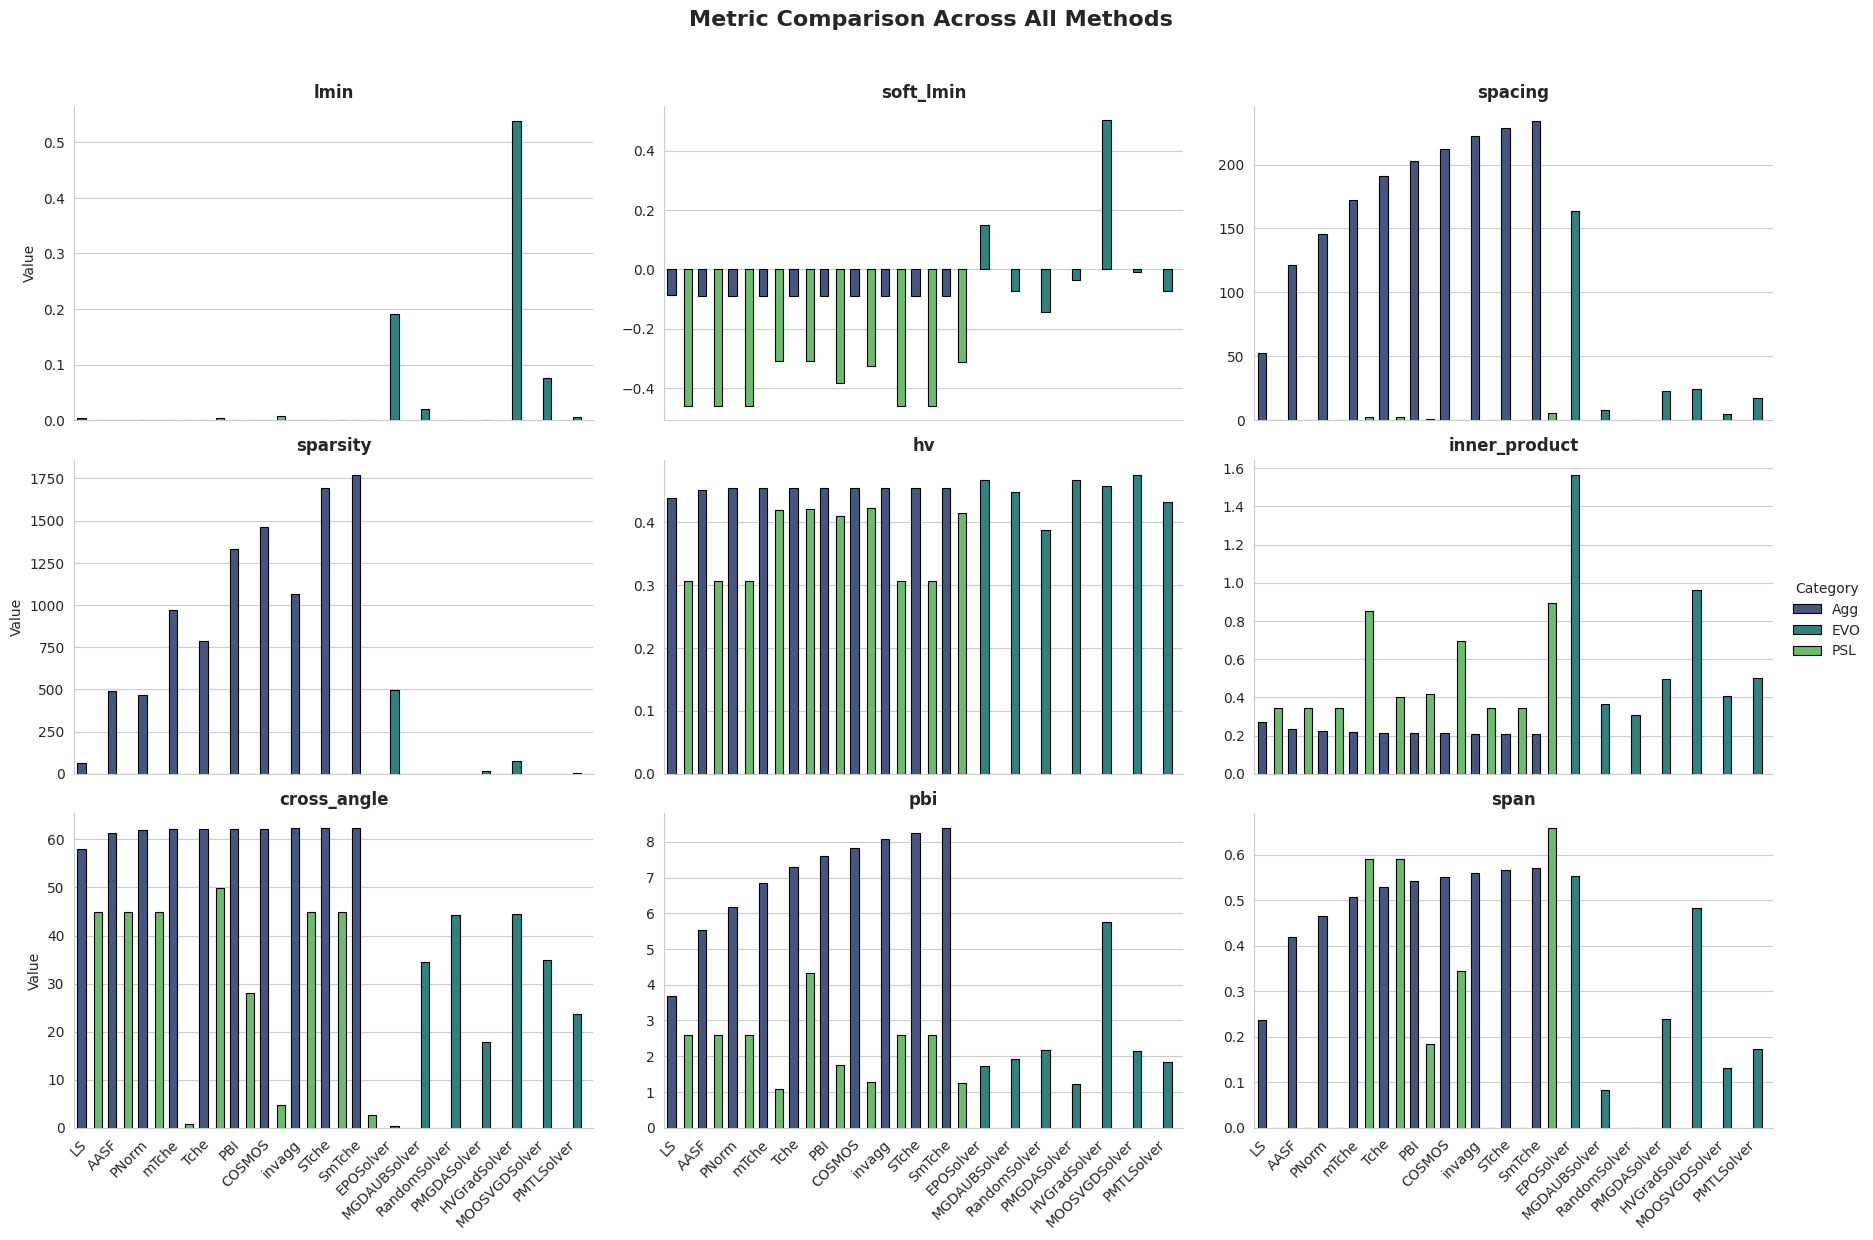

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from libmoon.metrics import metrics

# ==========================================
# 1. Data Collection Helper
# ==========================================
def collect_metrics(category_name, results_dict):
    collected_data = []
    
    if results_dict is None:
        return []

    for method_name, content in results_dict.items():
        try:
            # --- Extract Solution (Y) ---
            # Handle different key names (solution_y vs eval_y)
            if 'solution_y' in content:
                sols_tensor = content['solution_y']
            elif 'eval_y' in content:
                sols_tensor = content['eval_y']
            else:
                continue # Skip if no solution found
            
            # Convert to Numpy
            if hasattr(sols_tensor, 'detach'):
                sols_np = sols_tensor.detach().cpu().numpy()
            elif isinstance(sols_tensor, np.ndarray):
                sols_np = sols_tensor
            else:
                sols_np = np.array(sols_tensor)

            # --- Extract Preferences ---
            prefs_np = None
            if 'prefs' in content:
                p = content['prefs']
                if hasattr(p, 'detach'):
                    prefs_np = p.detach().cpu().numpy()
                elif isinstance(p, np.ndarray):
                    prefs_np = p
            
            # --- Compute Metrics ---
            # We pass prefs if they exist, otherwise some metrics (PBI/IP) might fail or return NaN
            # The libmoon metrics.compute_indicators typically expects prefs.
            if prefs_np is not None:
                met_dict = metrics.compute_indicators(sols_np, prefs=prefs_np, problem_name=method_name)
            else:
                # Fallback if your specific metrics function REQUIRES prefs
                # We create dummy prefs or skip preference-dependent metrics
                # For now, we assume prefs exist as per your snippet
                print(f"Warning: No prefs found for {method_name}, skipping pref-dependent metrics.")
                continue

            # --- Flatten for DataFrame ---
            for metric_name, metric_val in met_dict.items():
                collected_data.append({
                    "Category": category_name,
                    "Method": method_name,
                    "Metric": metric_name,
                    "Value": metric_val
                })
                
        except Exception as e:
            print(f"Error processing {category_name} - {method_name}: {str(e)}")
            
    return collected_data

# ==========================================
# 2. Build the Master DataFrame
# ==========================================
all_data = []

# Process each dictionary if it exists in your environment
if 'results_agg' in globals():
    all_data.extend(collect_metrics("Agg", results_agg))

if 'all_solver_results' in globals():
    all_data.extend(collect_metrics("EVO", all_solver_results))

if 'results_psl' in globals():
    all_data.extend(collect_metrics("PSL", results_psl))

# Create DataFrame
df = pd.DataFrame(all_data)

# ==========================================
# 3. Display Pivot Table (Nice Report)
# ==========================================
if not df.empty:
    # Pivot to make metrics columns (Method x Metric)
    pivot_df = df.pivot_table(
        index=["Category", "Method"], 
        columns="Metric", 
        values="Value"
    )

# This sorts by Category (alphabetical) and then by HV (Descending)
    if 'hv' in pivot_df.columns:
        pivot_df = pivot_df.sort_values(by=['Category', 'hv'], ascending=[True, False])
        
    print(f"\n{'='*80}")
    print(f"{'FULL METRICS REPORT':^80}")
    print(f"{'='*80}")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.precision', 4)
    display(pivot_df)
else:
    print("No data found to report.")

# ==========================================
# 4. Visualize with Graphs
# ==========================================
if not df.empty:
    sns.set_style("whitegrid")
    
    # Create a FacetGrid: One bar chart per Metric
    g = sns.catplot(
        data=df, 
        kind="bar",
        x="Method", 
        y="Value", 
        hue="Category",       # Color code by Agg/EVO/PSL
        col="Metric",         # Separate chart for each metric
        col_wrap=3,           # 3 charts per row
        height=4, 
        aspect=1.5,
        sharey=False,         # Independent Y-axis for each metric
        palette="viridis",
        edgecolor="black",
        linewidth=0.8
    )
    
    # Fix labels
    g.set_titles("{col_name}", fontweight='bold', size=12)
    g.set_axis_labels("", "Value")
    
    # Rotate x-axis labels for readability
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
            
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Metric Comparison Across All Methods", fontsize=16, fontweight='bold')
    plt.show()

In [14]:
import torch
import numpy as np
from sklearn.metrics import f1_score

# --- 1. CONFIGURATION ---
INPUT_DIM = X_test_torch.shape[1]
HIDDEN_DIM = 8  # Must match your Problem definition
y_true = y_test.values.ravel() if hasattr(y_test, 'values') else np.array(y_test).ravel()

# --- 2. HELPER FUNCTION (Recap) ---
def predict_with_flat_weights(flat_weights, X_input, input_dim, hidden_dim):
    if isinstance(flat_weights, np.ndarray): flat_weights = torch.FloatTensor(flat_weights)
    
    # Slicing logic
    w1_end = input_dim * hidden_dim
    b1_end = w1_end + hidden_dim
    w2_end = b1_end + hidden_dim
    
    W1 = flat_weights[:w1_end].reshape(hidden_dim, input_dim)
    b1 = flat_weights[w1_end:b1_end]
    W2 = flat_weights[b1_end:w2_end].reshape(hidden_dim, 1)
    b2 = flat_weights[w2_end:].reshape(1)
    
    h = torch.relu(torch.matmul(X_input, W1.T) + b1)
    logits = torch.matmul(h, W2) + b2
    return (logits > 0.0).float().view(-1).cpu().numpy()

# --- 3. MAIN EVALUATION LOOP ---
print(f"{'Solver':<10} | {'ID':<3} | {'CrossEntropy':<12} | {'Complexity':<12} | {'Test F1 Score':<12}")
print("-" * 65)

global_best_f1 = -1
global_best_info = {}

for solver_name, solver_data in results_agg.items():
    
    solutions_x = solver_data.get('result', {}).get('x', [])

    solutions_y = solver_data.get('solution_y', [])

    # 2. Handle 1D vs 2D array edge cases
    if isinstance(solutions_x, np.ndarray) or torch.is_tensor(solutions_x):
        if len(solutions_x.shape) == 1:
            solutions_x = [solutions_x] # Wrap single solution
            if len(solutions_y) > 0:
                solutions_y = [solutions_y] if not isinstance(solutions_y, list) else solutions_y

    # 3. Iterate through this solver's solutions
    for i, flat_weights in enumerate(solutions_x):
        # Skip scalar/empty weights
        if np.ndim(flat_weights) == 0: continue

        # PREDICT
        y_pred = predict_with_flat_weights(flat_weights, X_test_torch, INPUT_DIM, HIDDEN_DIM)
        
        # SCORE
        current_f1 = f1_score(y_true, y_pred, average='weighted')
        
        # Get losses for display (safely)
        ce_loss = solutions_y[i][0] if i < len(solutions_y) else 0.0
        comp_loss = solutions_y[i][1] if i < len(solutions_y) else 0.0
        
        # PRINT ROW
        print(f"{solver_name:<10} | {i:<3} | {ce_loss:.4f}       | {comp_loss:.4f}       | {current_f1:.4f}")
        
        # TRACK BEST
        if current_f1 > global_best_f1:
            global_best_f1 = current_f1
            global_best_info = {
                'solver': solver_name,
                'index': i,
                'weights': flat_weights,
                'f1': current_f1
            }

print("-" * 65)
print(f"🏆 GLOBAL BEST: Solver '{global_best_info['solver']}' (Index {global_best_info['index']})")
print(f"   F1 Score: {global_best_info['f1']:.4f}")





Solver     | ID  | CrossEntropy | Complexity   | Test F1 Score
-----------------------------------------------------------------
LS         | 0   | 0.6113       | 0.0028       | 0.5765
LS         | 1   | 0.6180       | 0.0027       | 0.5765
LS         | 2   | 0.6143       | 0.0030       | 0.5765
LS         | 3   | 0.5415       | 0.2854       | 0.7029
LS         | 4   | 0.3813       | 1.6334       | 0.7225
AASF       | 0   | 0.6109       | 0.0021       | 0.5765
AASF       | 1   | 0.6109       | 0.0018       | 0.5765
AASF       | 2   | 0.6109       | 0.0019       | 0.5765
AASF       | 3   | 0.5132       | 0.3574       | 0.7029
AASF       | 4   | 0.1917       | 3.4434       | 0.7225
PNorm      | 0   | 0.6109       | 0.0027       | 0.5765
PNorm      | 1   | 0.6109       | 0.0019       | 0.5765
PNorm      | 2   | 0.6109       | 0.0026       | 0.5765
PNorm      | 3   | 0.5065       | 0.3752       | 0.7029
PNorm      | 4   | 0.1463       | 4.0787       | 0.7225
mTche      | 0   | 0.6109      

In [15]:
# --- 3. MAIN EVALUATION LOOP ---
print(f"{'Solver':<10} | {'ID':<3} | {'CrossEntropy':<12} | {'Complexity':<12} | {'Test F1 Score':<12}")
print("-" * 65)

global_best_f1 = -1
global_best_info = {}

for solver_name, solver_data in all_solver_results.items():
    solutions_x = solver_data['result']['x']

    solutions_y = solver_data.get('solution_y', [])

    # 2. Handle 1D vs 2D array edge cases
    if isinstance(solutions_x, np.ndarray) or torch.is_tensor(solutions_x):
        if len(solutions_x.shape) == 1:
            solutions_x = [solutions_x] # Wrap single solution
            if len(solutions_y) > 0:
                solutions_y = [solutions_y] if not isinstance(solutions_y, list) else solutions_y

    # 3. Iterate through this solver's solutions
    for i, flat_weights in enumerate(solutions_x):
        # Skip scalar/empty weights
        if np.ndim(flat_weights) == 0: continue

        # PREDICT
        y_pred = predict_with_flat_weights(flat_weights, X_test_torch, INPUT_DIM, HIDDEN_DIM)
        
        # SCORE
        current_f1 = f1_score(y_true, y_pred, average='weighted')
        
        # Get losses for display (safely)
        ce_loss = solutions_y[i][0] if i < len(solutions_y) else 0.0
        comp_loss = solutions_y[i][1] if i < len(solutions_y) else 0.0
        
        # PRINT ROW
        print(f"{solver_name:<10} | {i:<3} | {ce_loss:.4f}       | {comp_loss:.4f}       | {current_f1:.4f}")
        
        # TRACK BEST
        if current_f1 > global_best_f1:
            global_best_f1 = current_f1
            global_best_info = {
                'solver': solver_name,
                'index': i,
                'weights': flat_weights,
                'f1': current_f1
            }

print("-" * 65)
print(f"🏆 GLOBAL BEST: Solver '{global_best_info['solver']}' (Index {global_best_info['index']})")
print(f"   F1 Score: {global_best_info['f1']:.4f}")

Solver     | ID  | CrossEntropy | Complexity   | Test F1 Score
-----------------------------------------------------------------
EPOSolver  | 0   | 0.0576       | 5.4443       | 0.7497
EPOSolver  | 1   | 0.3743       | 1.0657       | 0.8020
EPOSolver  | 2   | 0.4787       | 0.4680       | 0.7632
EPOSolver  | 3   | 0.5727       | 0.1955       | 0.5765
EPOSolver  | 4   | 0.6109       | 0.0086       | 0.5765
MGDAUBSolver | 0   | 0.6108       | 0.0092       | 0.5765
MGDAUBSolver | 1   | 0.5272       | 0.3177       | 0.6633
MGDAUBSolver | 2   | 0.5346       | 0.2983       | 0.6540
MGDAUBSolver | 3   | 0.5486       | 0.2614       | 0.6102
MGDAUBSolver | 4   | 0.5628       | 0.2233       | 0.5765
RandomSolver | 0   | 0.6109       | 0.0041       | 0.5765
RandomSolver | 1   | 0.6109       | 0.0077       | 0.5765
RandomSolver | 2   | 0.6109       | 0.0081       | 0.5765
RandomSolver | 3   | 0.6109       | 0.0136       | 0.5765
RandomSolver | 4   | 0.6109       | 0.0038       | 0.5765
PMGDASolver

In [27]:
import torch
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

f1_scores_psl = {}

for x in results_psl.keys():

    # --- 1. CONFIGURATION ---
    INPUT_DIM = X_test_torch.shape[1]
    HIDDEN_DIM = 8  # Must match your training configuration
    y_true = y_test.values.ravel() if hasattr(y_test, 'values') else np.array(y_test).ravel()

    # --- 2. PREDICTION FUNCTION ---
    def predict_with_flat_weights(flat_weights, X_input, input_dim, hidden_dim):
        # Ensure weights are a tensor on the same device as X_input
        if isinstance(flat_weights, np.ndarray): 
            flat_weights = torch.from_numpy(flat_weights).float()
        
        flat_weights = flat_weights.to(X_input.device)
        
        # Slicing logic
        w1_end = input_dim * hidden_dim
        b1_end = w1_end + hidden_dim
        w2_end = b1_end + hidden_dim
        
        W1 = flat_weights[:w1_end].reshape(hidden_dim, input_dim)
        b1 = flat_weights[w1_end:b1_end]
        W2 = flat_weights[b1_end:w2_end].reshape(hidden_dim, 1)
        b2 = flat_weights[w2_end:].reshape(1)
        
        h = torch.relu(torch.matmul(X_input, W1.T) + b1)
        logits = torch.matmul(h, W2) + b2
        return (logits > 0.0).float().view(-1).cpu().numpy()

    # --- 3. GENERATE WEIGHTS FROM PSL MODEL ---
    # print("⚡ Generating weights from PSL Hypernetwork...")

    # Extract Model and Preferences
    psl_model = results_psl[x]['model']
    prefs = results_psl[x]['prefs']

    # Ensure model is in eval mode and on the correct device
    device = next(psl_model.parameters()).device
    prefs = prefs.to(device)
    X_test_device = X_test_torch.to(device) 

    psl_model.eval()
    with torch.no_grad():
        # THIS IS THE KEY STEP: Pass preferences -> Get Weights
        generated_weights = psl_model(prefs) 

    # print(f"✓ Generated {len(generated_weights)} unique models.")

    # # --- 4. EVALUATE GENERATED MODELS ---
    # print(f"\n{'ID':<4} | {'Pref (Obj1/Obj2)':<20} | {'Test F1 Score':<12}")
    # print("-" * 45)

    best_psl_f1 = -1
    best_psl_idx = -1
    best_psl_weights = None

    for i, weights in enumerate(generated_weights):
        try:
            # Predict
            y_pred = predict_with_flat_weights(weights, X_test_device, INPUT_DIM, HIDDEN_DIM)
            
            # Score
            current_f1 = f1_score(y_true, y_pred, average='weighted')
            
            # Get pref for display
            pref_str = f"{prefs[i][0]:.2f} / {prefs[i][1]:.2f}"
            
            # Only print every 10th row to avoid cluttering screen
            # if i % 10 == 0 or current_f1 > best_psl_f1:
                # print(f"{i:<4} | {pref_str:<20} | {current_f1:.4f}")
            
            if current_f1 > best_psl_f1:
                best_psl_f1 = current_f1
                best_psl_idx = i
                best_psl_weights = weights

        except Exception as e:
            print(f"Error on index {i}: {e}")

    # print("-" * 45)
    # print(f"🏆 Best PSL Solution found at Index {best_psl_idx}")
    # print(f"   Preference used: {prefs[best_psl_idx].tolist()}")
    # print(f"   F1 Score: {best_psl_f1:.4f}")

    f1_scores_psl[x] = best_psl_f1

    # # --- 5. VISUALIZE WINNER ---
    # if best_psl_weights is not None:
    #     y_pred_best = predict_with_flat_weights(best_psl_weights, X_test_device, INPUT_DIM, HIDDEN_DIM)
    #     cm = confusion_matrix(y_true, y_pred_best)

    #     plt.figure(figsize=(6, 5))
    #     sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
    #                 xticklabels=['Good (0)', 'Bad (1)'],
    #                 yticklabels=['Good (0)', 'Bad (1)'])
    #     plt.xlabel('Predicted')
    #     plt.ylabel('Actual')
    #     plt.title(f'PSL Best Model (Idx {best_psl_idx})\nF1: {best_psl_f1:.4f}')
    #     plt.show()
print(f1_scores_psl)

{'LS': 0.5764705882352941, 'AASF': 0.5764705882352941, 'PNorm': 0.5764705882352941, 'mTche': 0.6641378585688767, 'Tche': 0.678274374460742, 'PBI': 0.6675, 'COSMOS': 0.657959714100065, 'invagg': 0.5764705882352941, 'STche': 0.5764705882352941, 'SmTche': 0.6721568627450981}


In [17]:
import torch
import numpy as np

# 1. Check Dimensions
input_dim = X_test_torch.shape[1]
hidden_dim = 8 # The value you are forcing
psl_output_size = 505 # From your printout

print(f"--- Dimension Check ---")
print(f"Your Input Data (X_test) columns: {input_dim}")
print(f"Target Hidden Dim: {hidden_dim}")
print(f"PSL Model Output Size: {psl_output_size}")

# Calculate what size SHOULD be
# Formula: (Input * Hidden) + Hidden_Bias + (Hidden * Output) + Output_Bias
expected_size = (input_dim * hidden_dim) + hidden_dim + (hidden_dim * 1) + 1
print(f"Expected weights needed: {expected_size}")

if expected_size == psl_output_size:
    print("✅ Dimensions match! The architecture is correct.")
else:
    print("❌ DIMENSION MISMATCH. The PSL model was trained on different data or config.")
    print(f"   (The PSL model expects input_dim = {(psl_output_size - 1) // (hidden_dim + 2) - 2}??)")

# 2. Check Weight Values
print(f"\n--- Weight Health Check ---")
# Generate one set of weights
psl_model = results_psl['LS']['model']
test_pref = torch.tensor([[0.5, 0.5]]).to(next(psl_model.parameters()).device)
with torch.no_grad():
    w = psl_model(test_pref).cpu().numpy().ravel()

print(f"Min Weight: {w.min():.4f}")
print(f"Max Weight: {w.max():.4f}")
print(f"Mean Weight: {w.mean():.4f}")
print(f"Std Dev:    {w.std():.4f}")

if np.isnan(w).any():
    print("💀 CRITICAL: Weights contain NaNs (Not a Number).")
elif abs(w.max()) > 100 or abs(w.min()) > 100:
    print("⚠️ CRITICAL: Weights are exploding (too large).")
elif w.std() < 0.0001:
    print("⚠️ CRITICAL: Weights are dead (all zeros or constant).")

--- Dimension Check ---
Your Input Data (X_test) columns: 61
Target Hidden Dim: 8
PSL Model Output Size: 505
Expected weights needed: 505
✅ Dimensions match! The architecture is correct.

--- Weight Health Check ---
Min Weight: -0.0200
Max Weight: 0.0012
Mean Weight: -0.0000
Std Dev:    0.0009


In [18]:
df = pd.DataFrame(all_data)
df.to_csv("output.csv", index=False)